Bybitの約定データの分布を確認する。


　
## Bybitの約定データ分析（正規性の分布）

### やりたいこと

約定データが正規分布に従う前処理方法を探し出す。
結論からいえば正規分布風な分布への加工は可能だが、統計的検定をパスするレベルには達しない。
失敗したケースもそれなりにノウハウになるだろうことから公開する。

1時間足のOLCVデータを使い以下を検証する。
* 生データ分布の確認  $$ T_1, T2,,,,,T_n $$
* 収益（前Tickとの差分） $$ (T_2-T_1), (T_3-T_2),,,, (T_{n}-T_{n-1}) $$
* 収益率（前Tickとの比率）$$ (T_2/T_1), (T_3/T_2),,,, (T_{n}/T_{n-1}) $$
* Log収益率（収益率のLogを取ったもの）$$ log(T_2/T_1), log(T_3/T_2),,,, log(T_{n}/T_{n-1}) $$

最後に「ファイナンス機械学習」の２章に買いてあるドルバーも作成する（があまり状況変わらない）。

### 検証方法
「pythonによるファイナンス」(13.1章）の方法に従い正規性検定をおこなう。
* ヒストグラムのプロット（https://seaborn.pydata.org/generated/seaborn.distplot.html）
* QQプロット(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)
* 統計的検定の実施 (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)

## 事前検証
正規分布に従う乱数を発生させ、上記検証方法で正規分布として判定できるか検証する。

具体的には、
*　分布がいわゆるベルカーブになっていること
* QQプロットが直線になっていること
* 検定結果がすべて p > 0.05 であること

を確認し、検証方法が正しいかを確認する。当然ながら正規分布に従う乱数を生成しているので上記条件はクリアする（はず）。


見た目がベルカーブにしたがっていることを確認する。


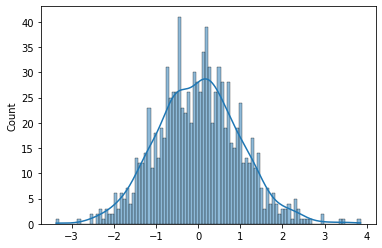

赤い線との乖離が小さい方が正規分布にしたがっていることを示す


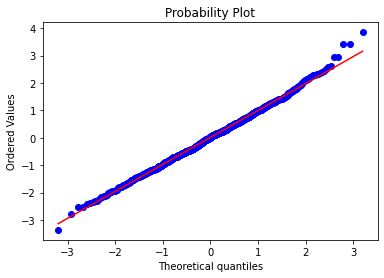

以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する
SkewtestResult(statistic=1.961984699592353, pvalue=0.049764265620542585)
KurtosistestResult(statistic=1.6784080083670045, pvalue=0.09326747529726702)
NormaltestResult(statistic=6.666437403984991, pvalue=0.03567808293933607)


In [92]:
#　正規分布にしたがう数値1000個の生成
import numpy as np
import scipy.stats as stats

random_norm = np.random.randn(1000)

# ヒストグラムの表示
import seaborn as sns
from matplotlib import pyplot as plt

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(random_norm, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('赤い線との乖離が小さい方が正規分布にしたがっていることを示す')
stats.probplot(random_norm, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(random_norm))
print(stats.kurtosistest(random_norm))
print(stats.normaltest(random_norm))

## bybitのデータで検証。


In [93]:
# bybitのデータを取得する関数の定義

import datetime

def get_bb_log(yyyy, mm, dd, symbol="BTCUSD"):
    """
    bybitからパラメーターに指定された日付の約定データを/tmpにダウンロードする。
    /tmpに一時保存することでキャッシュ機能を実現
    :param yyyy: 年（４桁）
    :param mm: 月
    :param dd: 日
    :param symbol: オプション：ディフォルトBTCUSD
    :return: /tmpにダウンロードしたファイル名
    """
    file_name = f'{symbol}{yyyy:04d}-{mm:02d}-{dd:02d}.csv.gz'
    tmp_file = '/tmp/'+ file_name

    if not os.path.exists(tmp_file):
        download_url = f'https://public.bybit.com/trading/{symbol}/{file_name}'
        print("download url=", download_url)
        request.urlretrieve(download_url, tmp_file)

    return tmp_file

def get_bb_df(yyyy, mm, dd):
    """
    bybitから約定データをダウンロードしpandasのDataFrameオブジェクトにする。
    :param yyyy: 年（４桁）
    :param mm: 月
    :param dd: 日
    :return: 約定データが入ったDataFrame
    """
    file = get_bb_log(yyyy, mm, dd)

    bb_df = pd.read_csv(file, index_col=0)
    bb_df.index = pd.to_datetime(bb_df.index, utc=True, unit='s')

    return bb_df


def resample_ohlcv(data, sample_time):
    """
    約定データからohlcvを作成する。
    timeに指定できるパラメータは文字列で以下のように指定する。
    15秒:'15S' / 1分: '1T' / 1時間: '1H'
    詳細はpadnasのドキュメント
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    :param data:　bybitの約定データの入ったDataFrame
    :param sample_time: サンプル間隔
    :return: ohlcvデータ
    """
    resample_df = data['price'].resample(sample_time).ohlc()
    resample_df['volume'] = data['size'].resample(sample_time).sum()
    return resample_df

def get_bb_df_past_days(days=10, start_day = None):
    """
    Bybitから過去から指定期間のデータをダウンロードしdfを返す。
    データが生成できていない可能性があるので２日前までの期間のデータをダウンロードする。
    :param days: データ取得期間
    :param start_day: 開始時間（指定しない場合は今日からdays+2日前）
    :return: 約定データが入ったdf
    """
    if not start_day:
        start_day = datetime.date.today() - datetime.timedelta(days=days+2)

    print('start:', start_day, "-> end:", start_day + datetime.timedelta(days=days))

    bb_df = None
    for i in range(days):
        target_day = start_day + datetime.timedelta(days=i)
        download_df = get_bb_df(target_day.year, target_day.month, target_day.day)
        if bb_df is None:
            bb_df = download_df
        else:
            bb_df = bb_df.append(download_df)

    return bb_df


10日分のデータをダウンロードし、価格の分布を調べる。

日付や期間にもよるが基本的には正規分布にしたがっていない。

start: 2021-09-14 -> end: 2021-09-24
見た目がベルカーブにしたがっていることを確認する。


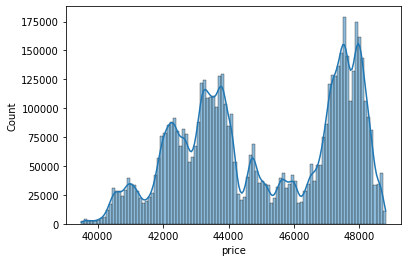

赤い線との乖離が小さい方が正規分布にしたがっていることを示す


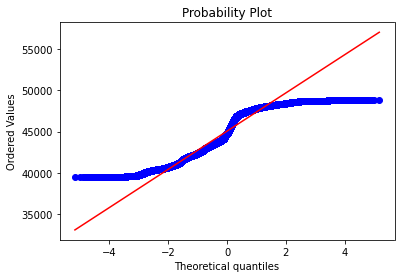

以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する
SkewtestResult(statistic=-131.05144853400958, pvalue=0.0)
KurtosistestResult(statistic=12595.213622343857, pvalue=0.0)
NormaltestResult(statistic=158656580.67463914, pvalue=0.0)


In [97]:
df = get_bb_df_past_days(10)

price = df['price']

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(price, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('直線にならんでいると正規分布にしたがっていることを示す')
stats.probplot(price, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(price))
print(stats.kurtosistest(price))
print(stats.normaltest(price))


約定毎の差分をとる。常に0.5ドル刻みで変化することが示されていて、分布の幅がない。

In [ ]:

price_diff = price.diff()

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(price_diff, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('直線にならんでいると正規分布にしたがっていることを示す')
stats.probplot(price_diff, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(price_diff))
print(stats.kurtosistest(price_diff))
print(stats.normaltest(price_diff))


1分足を作成し約定毎の差分をとる。

見た目がベルカーブにしたがっていることを確認する。


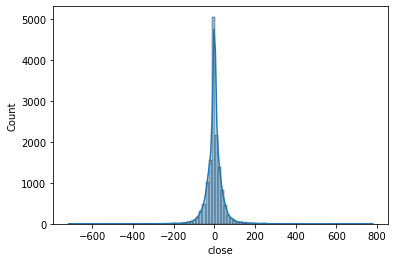

直線にならんでいると正規分布にしたがっていることを示す


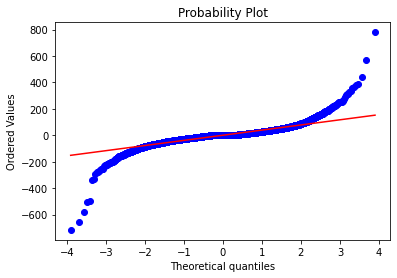

以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する
SkewtestResult(statistic=2.750267637794847, pvalue=0.005954660698969755)
KurtosistestResult(statistic=64.47282674224407, pvalue=0.0)
NormaltestResult(statistic=4164.309360214923, pvalue=0.0)


In [102]:
price = resample_ohlcv(df, '1T')['close']
price_diff = price.diff().dropna()

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(price_diff, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('直線にならんでいると正規分布にしたがっていることを示す')
stats.probplot(price_diff, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(price_diff))
print(stats.kurtosistest(price_diff))
print(stats.normaltest(price_diff))

1時間足を作成し約定毎の差分をとる。

見た目がベルカーブにしたがっていることを確認する。


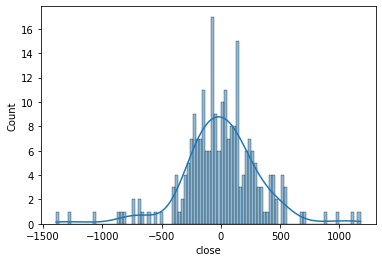

直線にならんでいると正規分布にしたがっていることを示す


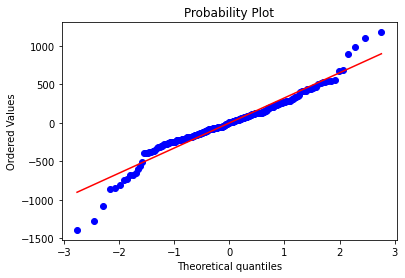

以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する
SkewtestResult(statistic=-2.1205822729647656, pvalue=0.03395697122501914)
KurtosistestResult(statistic=4.697416376169, pvalue=2.6347299871930947e-06)
NormaltestResult(statistic=26.56258978751312, pvalue=1.7061095545433092e-06)


In [103]:
price = resample_ohlcv(df, '60T')['close']
price_diff = price.diff().dropna()

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(price_diff, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('直線にならんでいると正規分布にしたがっていることを示す')
stats.probplot(price_diff, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(price_diff))
print(stats.kurtosistest(price_diff))
print(stats.normaltest(price_diff))


1時間足で比率をとる。

In [ ]:
price = resample_ohlcv(df, '60T')['close']
price_ratio = (price.shift(1) / price).dropna()

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(price_ratio, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('直線にならんでいると正規分布にしたがっていることを示す')
stats.probplot(price_ratio, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(price_ratio))
print(stats.kurtosistest(price_ratio))
print(stats.normaltest(price_ratio))



1時間足で比率のlogをとる。

見た目がベルカーブにしたがっていることを確認する。


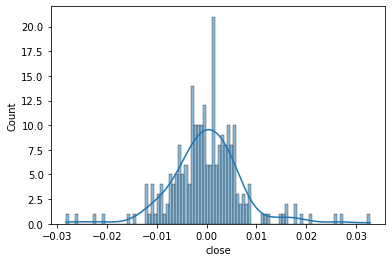

直線にならんでいると正規分布にしたがっていることを示す


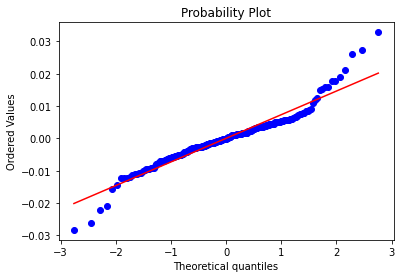

以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する
SkewtestResult(statistic=2.1056060522274977, pvalue=0.03523858650363982)
KurtosistestResult(statistic=5.087233756465695, pvalue=3.633239117710004e-07)
NormaltestResult(statistic=30.313524140101133, pvalue=2.615181705379797e-07)


In [106]:
price = resample_ohlcv(df, '60T')['close']
price_ratio = np.log((price.shift(1) / price).dropna())

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(price_ratio, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('直線にならんでいると正規分布にしたがっていることを示す')
stats.probplot(price_ratio, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(price_ratio))
print(stats.kurtosistest(price_ratio))
print(stats.normaltest(price_ratio))


# 上記の方法では見た目はベルカーブであるが正規分布とはいえない。

## 「ファイナンス機械学習」の２章に従い、ドルバーを作って検証する。

見た目がベルカーブにしたがっていることを確認する。


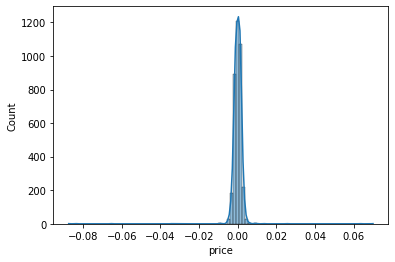

直線にならんでいると正規分布にしたがっていることを示す


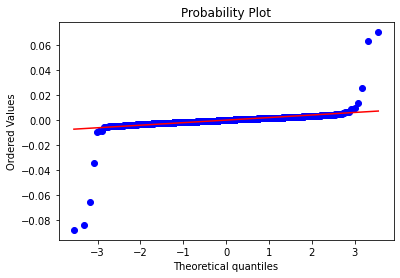

以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する
SkewtestResult(statistic=-58.40123293488074, pvalue=0.0)
KurtosistestResult(statistic=42.342524608581236, pvalue=0.0)
NormaltestResult(statistic=5203.593398542506, pvalue=0.0)


In [121]:
df['cumsum'] = df['size'].cumsum()
df['dollar'] = round(df['cumsum']/10_000_000)


dollar = df.groupby('dollar').mean()
dollar_returns = np.log((dollar['price'] / dollar['price'].shift(1)).dropna())

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(dollar_returns, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('直線にならんでいると正規分布にしたがっていることを示す')
stats.probplot(dollar_returns, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(dollar_returns))
print(stats.kurtosistest(dollar_returns))
print(stats.normaltest(dollar_returns))

In [ ]:
例外値を外す

0.003924669521405915
見た目がベルカーブにしたがっていることを確認する。


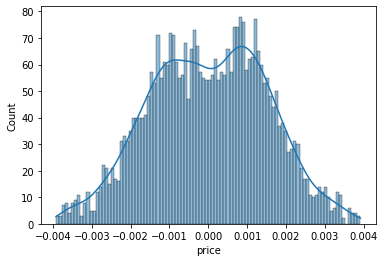

直線にならんでいると正規分布にしたがっていることを示す


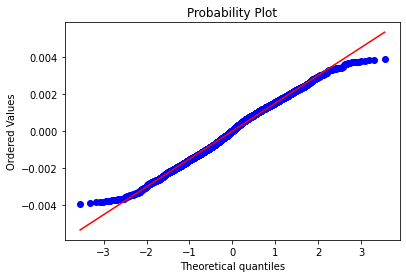

以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する
SkewtestResult(statistic=-1.2441942265436097, pvalue=0.2134280881201862)
KurtosistestResult(statistic=-8.31944491868504, pvalue=8.837621425939778e-17)
NormaltestResult(statistic=70.76118302839878, pvalue=4.309276280700489e-16)


In [122]:
q = dollar_returns.quantile(0.99)
print(q)

dollar_returns = dollar_returns[(dollar_returns < q) & (-q < dollar_returns)]

print('見た目がベルカーブにしたがっていることを確認する。')
sns.histplot(dollar_returns, bins=100, kde=True)
plt.show()

# QQプロットの表示
print('直線にならんでいると正規分布にしたがっていることを示す')
stats.probplot(dollar_returns, plot=plt)
plt.show()

# 統計的検定の実施
print('以下の統計数値のpvalueがすべて0.05を下回っていないことを確認する')
print(stats.skewtest(dollar_returns))
print(stats.kurtosistest(dollar_returns))
print(stats.normaltest(dollar_returns))




